<a href="https://colab.research.google.com/github/khwwang/coding-training/blob/master/230706_cats_boundingbox_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 고양이 얼굴 바운딩 박스 찾기

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
!gdown https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb

Downloading...
From: https://drive.google.com/uc?id=1-RBvPOYycsSpS7rVP0Pqwcbh18lZYDeb
To: /content/BBRegression.zip
100% 945k/945k [00:00<00:00, 111MB/s]


In [3]:
!unzip /content/BBRegression.zip

Archive:  /content/BBRegression.zip
   creating: BBRegression/
  inflating: BBRegression/README.dataset.txt  
  inflating: BBRegression/README.roboflow.txt  
   creating: BBRegression/test/
  inflating: BBRegression/test/cat-110_jpg.rf.919d96206faca75068ac5595928f4005.jpg  
  inflating: BBRegression/test/cat-110_jpg.rf.919d96206faca75068ac5595928f4005.xml  
  inflating: BBRegression/test/cat-123_jpg.rf.9a0878d7d6e110b302293109a66b43bf.jpg  
  inflating: BBRegression/test/cat-123_jpg.rf.9a0878d7d6e110b302293109a66b43bf.xml  
  inflating: BBRegression/test/cat-143_jpg.rf.61045dbe235b78c5fdf8d2267b0bea85.jpg  
  inflating: BBRegression/test/cat-143_jpg.rf.61045dbe235b78c5fdf8d2267b0bea85.xml  
  inflating: BBRegression/test/cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1d.jpg  
  inflating: BBRegression/test/cat-144_jpg.rf.50b4b01d0df37d977b1341837708aa1d.xml  
  inflating: BBRegression/test/cat-188_jpg.rf.4bb417309154766edeac39c9c9d083f7.jpg  
  inflating: BBRegression/test/cat-188_jpg.rf

In [4]:
# xml에서 바운딩 좌표 정보를 읽어오는 함수

import glob
import xml.etree.ElementTree as ET

# 함수 가져오기

def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):

        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df

In [5]:
Image_path = '/content/BBRegression'

In [6]:
import os
#os를 이용하여 path를 찾아 xml파싱하여 csv로 바꿔주기
file_name = 'label_cats.csv'
csv_path = os.path.join(Image_path, 'train')

xml_df = xml_to_csv(csv_path)
xml_df

,filename,width,height,class,xmin,ymin,xmax,ymax
0,cat-193_jpg.rf.0011b0901f709dad9f2017f2a3a3c1a...,224,224,cat,30,15,205,156
1,cat-280_jpg.rf.7f896ee30db7572742bb1d9d4faa8e5...,224,224,cat,6,10,66,79
2,cat-28_jpg.rf.27a874e0fa79267b8311563cde71394a...,224,224,cat,59,28,215,178
3,cat-13_jpg.rf.9a221a3efdcd6ed55aa1d0f2326af6d7...,224,224,cat,5,5,119,171
4,cat-127_jpg.rf.3ba0e31044319a31a94b28134a30793...,224,224,cat,59,54,187,213
...,...,...,...,...,...,...,...,...
86,cat-105_jpg.rf.c2a86a1bbbd2692274d6d6084512e92...,224,224,cat,110,1,225,113
87,cat-225_jpg.rf.646ee7ec20a7675f3906e85bb56dcd7...,224,224,cat,77,8,199,133
88,cat-227_jpg.rf.b0e39e49b4f074a8b151a2d130a1390...,224,224,cat,34,11,142,120
89,cat-155_jpg.rf.13b84cf25fef6cfda79c057e7c18743...,224,224,cat,34,1,204,87


In [7]:
xml_df.to_csv(file_name)

In [8]:
images = xml_df.iloc[:,0].values
images[:5]

array(['cat-193_jpg.rf.0011b0901f709dad9f2017f2a3a3c1a7.jpg',
       'cat-280_jpg.rf.7f896ee30db7572742bb1d9d4faa8e5c.jpg',
       'cat-28_jpg.rf.27a874e0fa79267b8311563cde71394a.jpg',
       'cat-13_jpg.rf.9a221a3efdcd6ed55aa1d0f2326af6d7.jpg',
       'cat-127_jpg.rf.3ba0e31044319a31a94b28134a30793e.jpg'],
      dtype=object)

In [9]:
# target data
points = xml_df.iloc[:,4:].values
points[:5]

array([[ 30,  15, 205, 156],
       [  6,  10,  66,  79],
       [ 59,  28, 215, 178],
       [  5,   5, 119, 171],
       [ 59,  54, 187, 213]])

In [10]:
import PIL

dataset_image = []
dataset_bbs = []

for file, point in zip(images,points):
  f = os.path.join(Image_path, 'train', file)
  image = PIL.Image.open(f)
  arr= np.array(image)
  dataset_image.append(arr)
  dataset_bbs.append(point)

In [11]:
dataset_images = np.array(dataset_image)
dataset_bbs= np.array(dataset_bbs)

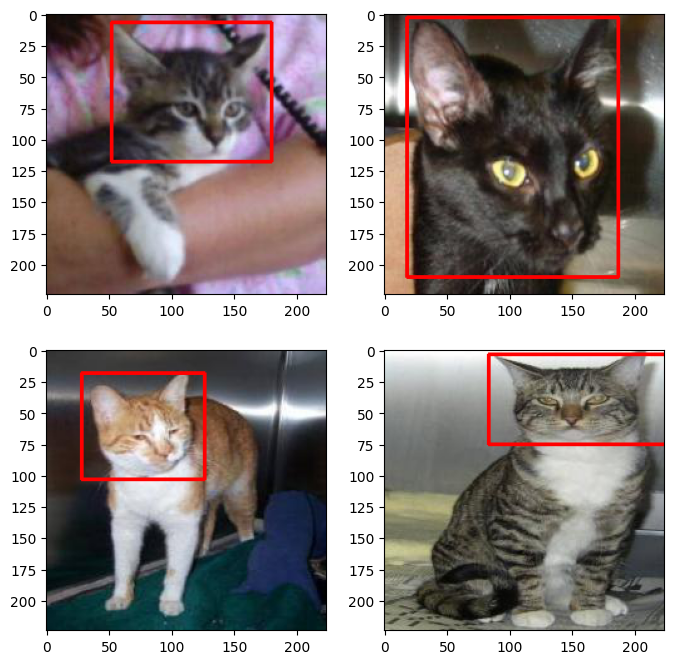

In [12]:
import cv2

samples = np.random.randint(91, size=4)

plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = dataset_bbs[idx].reshape(2, 2)
    img = cv2.rectangle(dataset_images[idx].copy(),
                        tuple(points[0]),
                        tuple(points[1]),
                        color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()

## 검증데이터 만들기

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(dataset_images, dataset_bbs, test_size=0.2, random_state=42)

In [14]:
X_train = X_train/255.
X_val = X_val/255.

In [15]:
y_train  =y_train.astype('float32')
y_val  =y_val.astype('float32')

In [16]:
from tensorflow.keras.applications import MobileNetV2

base = MobileNetV2(
    include_top = False,
    weights='imagenet',
    input_shape=(224,224,3)
)
base.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

In [42]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    base,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(4)
])

In [43]:
from keras.optimizers import Adam

model.compile(
    optimizer = Adam(learning_rate=0.0001),
    loss = 'mse',
    metrics = ['mse']
)

In [44]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

ckpt_path = './ckpt/cats_bbs.ckpt'
ckpt = ModelCheckpoint(
    ckpt_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss'
)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',factor=0.1,
    patience=2,
    verbose=1)

In [45]:
EPOCHS = 30
BATCH_SIZE = 16

history = model.fit (
    X_train, y_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    validation_data = (X_val, y_val),
    callbacks=[ckpt,reduce_lr],
    verbose = 1
)

Epoch 1/30
5/5 [==============================] - 7s 562ms/step - loss: 11885.1592 - mse: 11885.1592 - val_loss: 9046.1074 - val_mse: 9046.1074 - lr: 1.0000e-04
Epoch 2/30
5/5 [==============================] - 1s 350ms/step - loss: 8875.9619 - mse: 8875.9619 - val_loss: 8684.7900 - val_mse: 8684.7900 - lr: 1.0000e-04
Epoch 3/30
5/5 [==============================] - 0s 94ms/step - loss: 7200.9658 - mse: 7200.9658 - val_loss: 11870.5967 - val_mse: 11870.5967 - lr: 1.0000e-04
Epoch 4/30
4/5 [=======================>......] - ETA: 0s - loss: 6840.1733 - mse: 6840.1733
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
5/5 [==============================] - 0s 91ms/step - loss: 6730.1079 - mse: 6730.1079 - val_loss: 11391.4678 - val_mse: 11391.4678 - lr: 1.0000e-04
Epoch 5/30
5/5 [==============================] - 0s 89ms/step - loss: 6169.3384 - mse: 6169.3384 - val_loss: 11009.7930 - val_mse: 11009.7930 - lr: 1.0000e-05
Epoch 6/30
4/5 [=======================>..

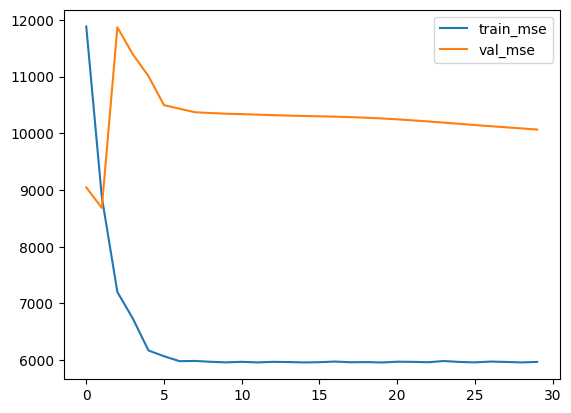

In [46]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.plot(hist['epoch'], hist['mse'], label='train_mse')
plt.plot(hist['epoch'], hist['val_mse'], label='val_mse')
plt.legend()
plt.show()

In [47]:
model.load_weights(ckpt_path)

## 모델 저장

In [48]:
# tensorflow 저장법
model.save('model_dir')

In [49]:
#keras 저장법
model.save('cats_bbs.h5')

## 모델 로딩

In [50]:
from keras.models import load_model

new_model = load_model('cats_bbs.h5')
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dense_9 (Dense)             (None, 128)               8028288   
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                      

In [51]:
## 테스트 데이터 로딩

In [52]:
fnames = glob.glob('/content/BBRegression/test' + '/*.jpg')
X_test = []
for f in fnames:
    image = PIL.Image.open(f)
    arr = np.array(image)
    X_test.append(arr)
X_test = np.array(X_test)
X_test = X_test.astype('float32')/255.
y_pred = model.predict(X_test).astype('int')
y_pred[:5]

1/1 [==============================] - 1s 970ms/step


array([[158, -26,  50, 100],
       [147, -24,  47,  93],
       [178, -29,  57, 113],
       [135, -21,  43,  85],
       [192, -31,  62, 121]])

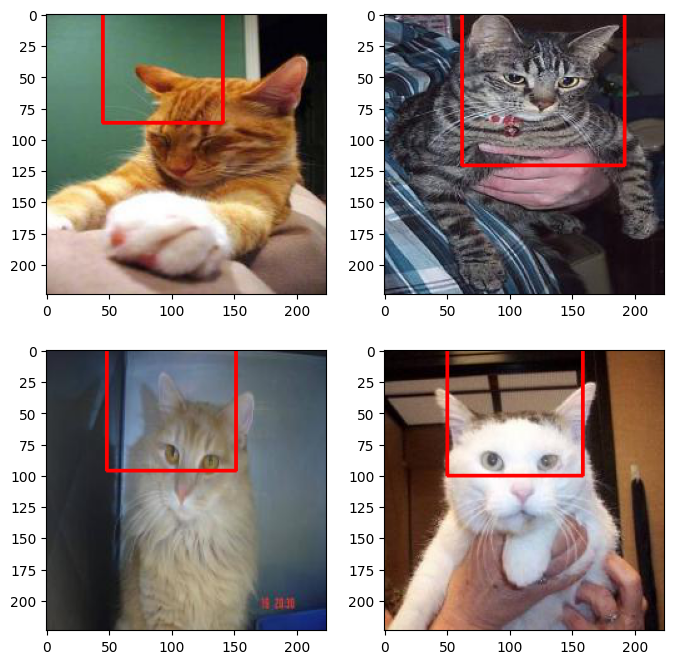

In [54]:
samples = np.random.randint(11, size=4)
plt.figure(figsize=(8, 8))
for i, idx in enumerate(samples):
    points = y_pred[idx].reshape(2, 2)
    img = cv2.rectangle(X_test[idx].copy(), tuple(points[0]),tuple(points[1]),color=(255, 0, 0),
                        thickness=2)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
plt.show()